
# Supervised Learning


### Intialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random

# Part 1: Comparing classifiers
## Datasets


In [3]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [4]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)

In [5]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]

t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [6]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

Plot the two training sets.

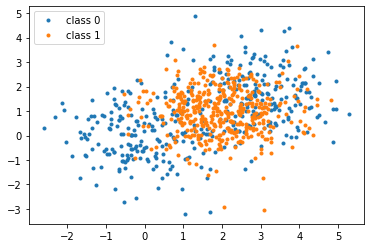

In [7]:
import pandas
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import operator

def show(X, y, marker='.'):
    labels = set(y)
    for lab in labels:
        plt.plot(X[y == lab][:, 1], X[y == lab][:, 0],
                 marker, label="class {}".format(lab))
    plt.legend()

#show(X_train, t_train) #first plot
show(X_train, t2_train) #second plot

## Binary classifiers

### Linear regression


In [8]:
def add_bias(X, b=1):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        bias.fill(b)
        return np.concatenate([bias, X], axis  = 1)


        
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)

    
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)
                

    import numpy as np
    
class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, gamma = 0.1, epochs=17, diff=0.0001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
       
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        self.theta = theta = np.zeros(m+1)
        theta-=gamma / k *  X_train.T @ (X_train @ theta - t_train)
        update = theta-gamma / k *  X_train.T @ (X_train @ theta - t_train) 
        
        
        while np.linalg.norm(update)-np.linalg.norm(theta) >= diff and i_2 <= 60:
            theta -= gamma / k *  X_train.T @ (X_train @ theta - t_train)
            update = theta-gamma / k *  X_train.T @ (X_train @ theta - t_train)
            
        
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.theta
        
        return score>threshold

diffs = [0.0001, 0.0003, 0.003, 0.007]
lin_reg_acc = []
c = NumpyLinRegClass()

for i in range(4):
    c.fit(X_train, t2_train, diff=diffs[i])
    lin_reg_acc.append((diffs[i],c.accuracy(X_val, t2_val)))
                       
print("Resultater (på forment (diff, accuracy)):",lin_reg_acc)

Antall interasjoner: 61 61
Antall interasjoner: 61 61
Antall interasjoner: 36 36
Antall interasjoner: 2 2
Resultater (på forment (diff, accuracy)): [(0.0001, 0.565), (0.0003, 0.565), (0.003, 0.5525), (0.007, 0.4775)]


### Logistic regression


In [18]:
def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, gamma = 0.1, epochs=200, diff=0.0001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1) 
        theta-= gamma / k *  X_train.T @ (self.forward(X_train) - t_train)  
        update = theta-gamma / k *  X_train.T @ (self.forward(X_train) - t_train)  
        i = 0
        
        while np.linalg.norm(update)-np.linalg.norm(theta) >= diff:
            theta -= gamma / k *  X_train.T @ (self.forward(X_train) - t_train) 
            update = theta-gamma / k *  X_train.T @ (self.forward(X_train) - t_train)
            i += 1
        
    
    def forward(self, X):
        return logistic(X @ self.theta)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')

    
log_reg_acc = []
c2 = NumpyLogReg()

for i in range(4):
    c2.fit(X_train, t2_train, diff=diffs[i])
    log_reg_acc.append((diffs[i],c2.accuracy(X_val, t2_val)))
                       
print("Resultater (på forment (diff, accuracy)):",log_reg_acc)

Resultater (på forment (diff, accuracy)): [(0.0001, 0.605), (0.0003, 0.6125), (0.003, 0.6), (0.007, 0.595)]


### *k*-nearest neighbors (*k*NN)


In [10]:
from collections import Counter

def distance_L2(a, b):
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

class PyClassifier():

    def accuracy(self,X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier 
        using the predict method"""
        predicted = [self.predict(a, **kwargs) for a in X_test]
        equal = len([(p, g) for (p,g) in zip(predicted, y_test) if p==g])
        return equal / len(y_test)
    

class PykNNClassifier(PyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def get_predicted(self, X):
        predicted = [self.predict(a) for a in X]
        return predicted
    
    def predict(self, a):
        X = self.X_train
        y = self.y_train
        distances = [(self.dist(a, b), b, c) for (b, c) in zip(X, y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0: k]]
        

        return majority(predictors)
    
x = range(1, 20, 2)
knn_acc = []

for k in x:
    c3 = PykNNClassifier(k=k)
    c3.fit(X_train, t2_train)
    knn_acc.append((k, c3.accuracy(X_val, t2_val)))

print("Resultater (på forment (k, accuracy)):", knn_acc)

Resultater (på forment (k, accuracy)): [(1, 0.67), (3, 0.68), (5, 0.7125), (7, 0.735), (9, 0.7325), (11, 0.7375), (13, 0.7475), (15, 0.7525), (17, 0.75), (19, 0.7525)]


### Simple perceptron


In [11]:

class PyPerClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1):

        X_train = [[1]+list(x) for x in X_train]     
        self.dim = dim = len(X_train[0])
        self.weights = weights = [0 for _ in range(dim)]
   

        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    weights[i] += eta * (t - y) * x[i]
        
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score
    
    def get_predicted(self, X):
        predicted = [self.predict(a) for a in X]
        return predicted
    
    def predict(self, x):
        """Predict the value for the item x"""
        x = [1] + list(x)
        score = self.forward(x)
        return int(score > 0)
    
c4 = PyPerClassifier()
c4.fit(X_train, t2_train)
c4.accuracy(X_val, t2_val)

0.6475

## Summary


| Classifier | Paramether | Accuracy         
| :- |-------------: | :-:
|  Linear regression | 17 epochs  | 0.5075 
|  Linear regression | diff on 0.0001 |  0.6025
|  Linear regression | diff on 0.003|   0.5525 
|  Linear regression | diff on 0.0003|  0.5925
| Logistic regression | 17 epochs |  0.6
| Logistic regression | 200 epochs |  0.62
| Logistic regression | 0.0001 |  0.605
| Logistic regression | 0.0003 |  0.6125
| Logistic regression | 0.003 |  0.6
| Logistic regression | 0.007 |  0.595
| KNN | 3 |  0.68
| KNN| 11 |  0.7375
| KNN | 15 and 19 |  0.7525
| PyPer |  |  0.6475



## Multi-class classifiers


### *k*NN


In [12]:
x = range(1, 20, 2)
knn_acc_multi = []

for k in x:
    c4 = PykNNClassifier(k=k)
    c4.fit(X_train, t_train)
    knn_acc_multi.append((k,c4.accuracy(X_val, t_val)))
    
print("Resultater (på forment (k, accuracy)):", knn_acc_multi)

Resultater (på forment (k, accuracy)): [(1, 0.6625), (3, 0.675), (5, 0.7075), (7, 0.73), (9, 0.7425), (11, 0.7475), (13, 0.75), (15, 0.7575), (17, 0.7525), (19, 0.755)]


| Classifier | Paramether | Accuracy         
| :- |-------------: | :-:
| KNN Multi Class| 15 |  0.7575
| KNN Multi Class |  17 | 0.7525
| KNN Multi Class |  19 | 0.755




### Logistic regression "one-vs-rest"


In [13]:
one_rest_acc = []

for i in range(len(set(t_train))):
    t = []
    v = []
    
    for c in t_train:
        if c == i:
            t.append(1)
        else:
            t.append(0)
            
    for c in t_val:
        if c == i:
            v.append(1)
        else:
            v.append(0)
            
    c5 = NumpyLogReg()
    c5.fit(X_train, t)
    one_rest_acc.append(c5.accuracy(X_val, v))

print("Accuracy med", len(set(t_train)),"klasser:",one_rest_acc)

Accuracy med 3 klasser: [0.9075, 0.605, 0.8575]


### Discuss


| Classifier | Paramether | Accuracy       
| :- |-------------: | :-:  
| One-vs-rest| 0.0001 |  0.9075
| One-vs-rest |  0.0001 | 0.605
| One-vs-rest |  0.0001 | 0.8575
| One-vs-rest|  0.007 |  0.845
| One-vs-rest |  0.007 | 0.595
| One-vs-rest |  0.007  | 0.84
| Logistic regression | 0.0001 |  0.605
| Logistic regression | 0.007 |  0.595


As we can see here, the modified logistic regression classifier has better results for class 0 and 2 (although this might be a result of overfitting, at leat when the diff is set to 0.0001). 
Class 1, however, has the exact same result as the original classifier, the results are the same. 
If we look at the plot for the original classifier, we can see that the class 1 is hard
to separate from the other classes, which might be the reason for the low accuracy in both classifiers. 

Class 0 had slightly better accuracy than class 2.

## Adding non-linear features

In [19]:
X_train_non_lin = np.zeros([800, 5])
X_val_non_lin = np.zeros([400, 5])

for i, e in enumerate(X_train):
    x, y, z  = np.square(e[0]), np.square(e[1]), e[0]*e[1] 
    new = np.append(e, np.array([x, y, z]))
   
    X_train_non_lin[i] = np.array(new)

for i, v in enumerate(X_val):
    x, y, z  = np.square(v[0]), np.square(v[1]), v[0]*e[1] 
    new = np.append(v, np.array([x, y, z]))

    X_val_non_lin[i] = np.array(new)

acc_non_linear = []
c6 = NumpyLinRegClass()
c6.fit(X_train_non_lin, t2_train)
acc_non_linear.append(c6.accuracy(X_val_non_lin, t2_val))

c7 = NumpyLogReg()
c7.fit(X_train_non_lin, t2_train)
acc_non_linear.append(c7.accuracy(X_val_non_lin, t2_val))

x = range(1, 20, 2)
knn = []
for k in x:
    c8 = PykNNClassifier()
    c8.fit(X_train_non_lin, t2_train)
    knn.append((k, c8.accuracy(X_val_non_lin, t2_val)))
acc_non_linear.append(knn)


c9 = PyPerClassifier()
c9.fit(X_train_non_lin, t2_train)
acc_non_linear.append(c9.accuracy(X_val_non_lin, t2_val))

print(acc_non_linear)

Antall interasjoner: 61 61
[0.515, 0.67, [(1, 0.6625), (3, 0.68), (5, 0.685), (7, 0.695), (9, 0.715), (11, 0.7275), (13, 0.7375), (15, 0.74), (17, 0.735), (19, 0.7275)], 0.605]



| | Linear  | Logistic  | Knn | PyPer  
| --- | --- | --- | --- | --- |
|**Old**| 0.6025 |0.605 |  0.7525 | 0.6475
|**New**| 0.515  |  0.67 |  0.74 |0.605

As we can see from the results, the non-linear features actually made accuracys worse for every classifier except the logistic regression classifier. 